<a href="https://colab.research.google.com/github/ioanabuze/DE_Group_Project_2020/blob/master/Amazon_Review_Weak_Labelling_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Loading Data, Installing Libraries and Setup

In [0]:
# Code here to push the Notebook to Git

In [0]:
!pip install snorkel

In [0]:
import nltk
nltk.download("popular")
nltk.download('vader_lexicon')
nltk.download('brown')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [0]:
 # pyspark setup

!pip install pyspark
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd "/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project"

/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project


In [0]:
from snorkel.labeling.apply.spark import SparkLFApplier
from snorkel.labeling import MajorityLabelVoter
from snorkel.labeling import labeling_function, LFAnalysis, LabelModel, PandasLFApplier
from snorkel.preprocess import preprocessor
from snorkel.labeling import filter_unlabeled_dataframe
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

import nltk
import re
import string
import spacy

from functools import reduce
from wordcloud import WordCloud
from textblob import TextBlob 
import pyspark.sql.functions as f
from textblob import TextBlob

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

from snorkel.utils import probs_to_preds


In [0]:
import os 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

COLAB_NOTEBOOKS_DATA_PATH="/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project"
SPARK_ARCHIVE='spark-2.4.5-bin-hadoop2.7.tgz'
if SPARK_ARCHIVE not in os.listdir(COLAB_NOTEBOOKS_DATA_PATH):
  !wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

SPARK_ARTIFACTS='spark-2.4.5-bin-hadoop2.7'
if SPARK_ARTIFACTS not in os.listdir(COLAB_NOTEBOOKS_DATA_PATH):
  !tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/spark-2.4.5-bin-hadoop2.7"

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import findspark
findspark.init()

import pyspark
from pyspark.sql import SQLContext

In [0]:
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [0]:
# Load the Data

# Make a subset of our dataframe using pandas and keep only the columns we need, remove rows with NaN
# Switch this back to Spark once we figure out the CSV formatting issue
amazon_reviews_dataset_pd_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Engineering Group Project/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
amazon_reviews_dataset_pd_df = pd.concat([amazon_reviews_dataset_pd_df['reviews.rating'],amazon_reviews_dataset_pd_df['reviews.text']], axis=1)
amazon_reviews_dataset_pd_df = amazon_reviews_dataset_pd_df.dropna()
amazon_reviews_dataset_pd_df.rename(columns={"reviews.rating": "reviews_rating", "reviews.text": "reviews_text"}, inplace=True)
amazon_reviews_dataset_pd_df

# Convert pandas DF to spark dataframe
amazon_reviews_dataset_sql_context = sqlContext.createDataFrame(amazon_reviews_dataset_pd_df)
amazon_reviews_dataset_sql_context = amazon_reviews_dataset_sql_context.dropna(subset=["reviews_rating", "reviews_text"])

# Convert spark dataframe to RDD
amazon_reviews_dataset_rdd = amazon_reviews_dataset_sql_context.rdd

In [0]:
 # Temp view for maniputing the data using SQL queries
amazon_reviews_dataset_sql_context.createOrReplaceTempView('amazon_reviews')

# Spliting the review text by review level, these will be the basis for learning information about the data that
# can be used for creating heuristics for our labeling functions. 

amazon_reviews_level1 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 1")
amazon_reviews_level2 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 2")
amazon_reviews_level3 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 3")
amazon_reviews_level4 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 4")
amazon_reviews_level5 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 5")

Code to split the data by review level and process it to create the wordcloud 

https://towardsdatascience.com/natural-language-processing-in-apache-spark-using-nltk-part-2-2-5550b85f3340


In [0]:
def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text
                                  if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(15)) for tag in cfd.conditions())

def top15_frequent_adjectives(txt):
  tagdict = findtags('JJ', nltk.pos_tag(txt))
  for tag in sorted(tagdict):
    print(tag, tagdict[tag])

In [0]:
print("Top 15 adjectives for Review Level 1")
txt = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level1.select('reviews_text').collect()))
df = top15_frequent_adjectives(txt)

Top 15 adjectives for Review Level 1
JJ [('same', 10), ('old', 9), ('last', 9), ('first', 8), ('other', 7), ('good', 6), ('great', 6), ('apps', 6), ('bad', 5), ('available', 5), ('slow', 5), ('terrible', 5), ('unable', 4), ('new', 4), ('few', 4)]
JJR [('more', 14), ('less', 6), ('larger', 4), ('Less', 2), ('smaller', 1), ('better', 1), ('Worse', 1)]
JJS [('newest', 3), ('Best', 3), ('lowest', 2), ('biggest', 1), ("'newest", 1), ('hottest', 1), ('best', 1)]


In [0]:
amazon_reviews_level1.count()

63

In [0]:
print("Top 15 adjectives for Review Level 2")
txt = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level2.select('reviews_text').collect()))
df =top15_frequent_adjectives(txt)

Top 15 adjectives for Review Level 2
JJ [('great', 5), ('other', 5), ('old', 4), ('good', 4), ('dark', 3), ('little', 3), ('sure', 3), ('much', 3), ('proper', 2), ('useful', 2), ('worth', 2), ('responsive', 2), ('limited', 2), ('user', 2), ('echo', 2)]
JJR [('better', 5), ('louder', 2), ('more', 1)]
JJS [('best', 2), ('most', 2), ('biggest', 1), ('Most', 1)]


In [0]:
amazon_reviews_level2.count()

54

In [0]:
print("Top 15 adjectives for Review Level 3")
txt = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level3.select('reviews_text').collect()))
df =top15_frequent_adjectives(txt)

Top 15 adjectives for Review Level 3
JJ [('good', 47), ('great', 28), ('old', 19), ('ok', 15), ('other', 13), ('able', 12), ('slow', 12), ('little', 11), ('first', 11), ('small', 10), ('new', 9), ('sure', 9), ('fine', 9), ('few', 8), ('easy', 8)]
JJR [('better', 9), ('more', 9), ('larger', 5), ('less', 3), ('higher', 3), ('easier', 2), ('older', 1), ('longer', 1), ('slower', 1), ('bigger', 1), ('harder', 1), ('prettier', 1), ('cheaper', 1), ('faster', 1)]
JJS [('best', 11), ('most', 3), ('biggest', 3), ('latest', 2), ('priciest', 1), ('worst', 1), ('lowest', 1), ('youngest', 1)]


In [0]:
amazon_reviews_level3.count()

197

In [0]:
print("Top 15 adjectives for Review Level 4")
txt = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level4.select('reviews_text').collect()))
df =top15_frequent_adjectives(txt)

Top 15 adjectives for Review Level 4
JJ [('great', 254), ('good', 202), ('easy', 137), ('little', 97), ('old', 90), ('other', 86), ('nice', 60), ('new', 59), ('only', 58), ('able', 46), ('much', 42), ('Good', 42), ('small', 41), ('perfect', 41), ('free', 36)]
JJR [('more', 61), ('better', 50), ('easier', 20), ('older', 13), ('bigger', 11), ('less', 10), ('cheaper', 9), ('lower', 8), ('larger', 8), ('smaller', 8), ('slower', 7), ('weather', 4), ('earlier', 3), ('louder', 3), ('Better', 3)]
JJS [('best', 31), ('most', 21), ('Most', 8), ('biggest', 5), ('least', 4), ('Best', 4), ('latest', 3), ('highest', 3), ('smallest', 2), ('lightest', 2), ('guest', 2), ('greatest', 1), ('cheapest', 1), ('lowest', 1), ('brightest', 1)]


In [0]:
amazon_reviews_level4.count()

1208

In [0]:
print("Top 15 adjectives for Review Level 5")
txt = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level5.select('reviews_text').collect()))
df =top15_frequent_adjectives(txt)

Top 15 adjectives for Review Level 5
JJ [('great', 804), ('easy', 427), ('old', 292), ('good', 285), ('other', 187), ('new', 179), ('able', 155), ('perfect', 143), ('much', 137), ('nice', 116), ('happy', 114), ('many', 113), ('smart', 101), ('first', 89), ('little', 89)]
JJR [('more', 188), ('better', 109), ('older', 61), ('easier', 58), ('larger', 33), ('smaller', 27), ('bigger', 25), ('less', 20), ('lighter', 15), ('cheaper', 15), ('lower', 11), ('faster', 11), ('newer', 10), ('happier', 9), ('higher', 8)]
JJS [('best', 152), ('most', 33), ('Best', 24), ('least', 12), ('latest', 10), ('youngest', 6), ('greatest', 5), ('honest', 5), ('nest', 4), ('Most', 3), ('fastest', 2), ('oldest', 2), ('biggest', 2), ('simplest', 2), ('longest', 2)]


In [0]:
amazon_reviews_level5.count()

3478

In [0]:
# Train/Test Split - 80/20 
df_train, df_test = amazon_reviews_dataset_rdd.randomSplit([0.8, 0.2], seed=42)

# Code to convert our y_test values into positive/negative and neutral and convert it to series, as input for the accuracy comparision later.
Y_test = df_test.toDF()
Y_test = Y_test.toPandas()

Y_test.loc[Y_test['reviews_rating'] == 1, 'reviews_rating'] = 0
Y_test.loc[Y_test['reviews_rating'] == 2, 'reviews_rating'] = 0
Y_test.loc[Y_test['reviews_rating'] == 3, 'reviews_rating'] = 2
Y_test.loc[Y_test['reviews_rating'] == 4, 'reviews_rating'] = 1
Y_test.loc[Y_test['reviews_rating'] == 5, 'reviews_rating'] = 1

Y_test = Y_test['reviews_rating']

## 2. Writing Labeling Functions (LFs)

We define constants to represent the class labels for: 

- Rating one = 0
- Rating two = 1 
- Rating three = 2
- Rating four = 3
- Rating five = 4
- Abstain: -1

In [0]:
# Set voting values

NEGATIVE = 0
POSITIVE = 1
NEUTRAL = 2

ABSTAIN = -1

The first set of labelling functions to classfy based of the presence of some 

In [0]:
ReviewNEGATIVE =  r"(same|old|bad|slow|terrible|unable|few|worse|less|worse|limited)"

# Top 15 adjectives for Review Level 1
# JJ [('same', 10), ('old', 9), ('last', 9), ('first', 8), ('other', 7), ('good', 6), ('great', 6), ('apps', 6), ('bad', 5), ('available', 5), ('slow', 5), ('terrible', 5), ('unable', 4), ('new', 4), ('few', 4)]
# JJR [('more', 14), ('less', 6), ('larger', 4), ('Less', 2), ('smaller', 1), ('better', 1), ('Worse', 1)]
# JJS [('newest', 3), ('Best', 3), ('lowest', 2), ('biggest', 1), ("'newest", 1), ('hottest', 1), ('best', 1)]
# 63 Rows in DF

# Top 15 adjectives for Review Level 2
# JJ [('great', 5), ('other', 5), ('old', 4), ('good', 4), ('dark', 3), ('little', 3), ('sure', 3), ('much', 3), ('proper', 2), ('useful', 2), ('worth', 2), ('responsive', 2), ('limited', 2), ('user', 2), ('echo', 2)]
# JJR [('better', 5), ('louder', 2), ('more', 1)]
# JJS [('best', 2), ('most', 2), ('biggest', 1), ('Most', 1)]
# 54 Rows in DF

ReviewNEUTRAL = r"(ok|fine)" 

# Top 15 adjectives for Review Level 3
# JJ [('good', 47), ('great', 28), ('old', 19), ('ok', 15), ('other', 13), ('able', 12), ('slow', 12), ('little', 11), ('first', 11), ('small', 10), ('new', 9), ('sure', 9), ('fine', 9), ('few', 8), ('easy', 8)]
# JJR [('better', 9), ('more', 9), ('larger', 5), ('less', 3), ('higher', 3), ('easier', 2), ('older', 1), ('longer', 1), ('slower', 1), ('bigger', 1), ('harder', 1), ('prettier', 1), ('cheaper', 1), ('faster', 1)]
# JJS [('best', 11), ('most', 3), ('biggest', 3), ('latest', 2), ('priciest', 1), ('worst', 1), ('lowest', 1), ('youngest', 1)]
# 197 Rows in DF

ReviewPOSITIVE = r"(great|good|easy|reliable|nice|new|perfect|better|happy)" 

# Top 15 adjectives for Review Level 4
# JJ [('great', 254), ('good', 202), ('easy', 137), ('little', 97), ('old', 90), ('other', 86), ('nice', 60), ('new', 59), ('only', 58), ('able', 46), ('much', 42), ('Good', 42), ('small', 41), ('perfect', 41), ('free', 36)]
# JJR [('more', 61), ('better', 50), ('easier', 20), ('older', 13), ('bigger', 11), ('less', 10), ('cheaper', 9), ('lower', 8), ('larger', 8), ('smaller', 8), ('slower', 7), ('weather', 4), ('earlier', 3), ('louder', 3), ('Better', 3)]
# JJS [('best', 31), ('most', 21), ('Most', 8), ('biggest', 5), ('least', 4), ('Best', 4), ('latest', 3), ('highest', 3), ('smallest', 2), ('lightest', 2), ('guest', 2), ('greatest', 1), ('cheapest', 1), ('lowest', 1), ('brightest', 1)]
# 1208 Rows in DF

# Top 15 adjectives for Review Level 5
# JJ [('great', 804), ('easy', 427), ('old', 292), ('good', 285), ('other', 187), ('new', 179), ('able', 155), ('perfect', 143), ('much', 137), ('nice', 116), ('happy', 114), ('many', 113), ('smart', 101), ('first', 89), ('little', 89)]
# JJR [('more', 188), ('better', 109), ('older', 61), ('easier', 58), ('larger', 33), ('smaller', 27), ('bigger', 25), ('less', 20), ('lighter', 15), ('cheaper', 15), ('lower', 11), ('faster', 11), ('newer', 10), ('happier', 9), ('higher', 8)]
# JJS [('best', 152), ('most', 33), ('Best', 24), ('least', 12), ('latest', 10), ('youngest', 6), ('greatest', 5), ('honest', 5), ('nest', 4), ('Most', 3), ('fastest', 2), ('oldest', 2), ('biggest', 2), ('simplest', 2), ('longest', 2)]
# 3478 Rows in DF

In [0]:
# labelling functions based off specific words
@labeling_function()
def review_NEGATIVE(x):
      return NEGATIVE if re.search(ReviewNEGATIVE, x.reviews_text.lower()) else ABSTAIN

@labeling_function()
def review_NEUTRAL(x):
    return NEUTRAL if re.search(ReviewNEUTRAL, x.reviews_text.lower()) else ABSTAIN

@labeling_function()
def review_POSITIVE(x):
    return POSITIVE if re.search(ReviewPOSITIVE, x.reviews_text.lower()) else ABSTAIN

The next heuristic that we are looking at is the number of word that the unhappy customers write to understand if there is a significant difference 
between our five rating levels.

In [0]:
def get_avg_wordcount(DF):
  df = DF.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' ')))

  totalwords = df.groupBy().sum().collect()[0][0]
  colcount = DF.count()

  avgwordcount = totalwords/colcount

  return avgwordcount

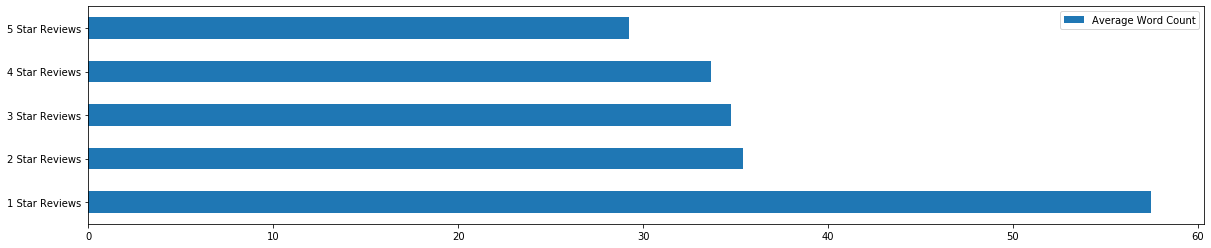

In [0]:
pandD = pd.DataFrame(data = [get_avg_wordcount(amazon_reviews_level1),
                             get_avg_wordcount(amazon_reviews_level2),
                             get_avg_wordcount(amazon_reviews_level3),
                             get_avg_wordcount(amazon_reviews_level4),
                             get_avg_wordcount(amazon_reviews_level5)], columns=['Average Word Count'], index=['1 Star Reviews',
                                                                                                              '2 Star Reviews',
                                                                                                              '3 Star Reviews',
                                                                                                              '4 Star Reviews',
                                                                                                              '5 Star Reviews'])
                             
pandD.plot.barh(figsize=(20,4))

The clearest trend is that very unhappy customrs tend to write very long reviews and the happiest customers the shortest. 

In [0]:
@labeling_function()
def pos_string_length(x):
  return POSITIVE if len(x.reviews_text.split()) <= 30 else ABSTAIN

In [0]:
@labeling_function()
def neg_string_length(x):
  return NEGATIVE if len(x.reviews_text.split()) >= 40 else ABSTAIN

In [0]:
def getSentiment(text):
    x = {}
    x["polarity"] = TextBlob(text).sentiment.polarity
    x["subjectivity"] = TextBlob(text).sentiment.subjectivity 
    return x

In [0]:
@labeling_function()
def textblob_polarity(x):
    x = getSentiment(x.reviews_text)

    if x["polarity"] >= 0.2:
      return POSITIVE 
    if x["polarity"] >= -0.2:
      return NEUTRAL
    if x["polarity"] < -0.2:
      return NEGATIVE
    else:
      return ABSTAIN

## 3. Labelling, Analysis and Accuracy

In [0]:
# Kept the the combination of lablling functions that give us the best accuracy score
labelingfunctions = [review_NEUTRAL, review_POSITIVE, textblob_polarity, pos_string_length]

In [0]:
applier = SparkLFApplier(lfs=labelingfunctions)

L_train = applier.apply(data_points=df_train)
L_test = applier.apply(data_points=df_test)

Need to write somethign here about the decision process on how we dealt with conflicts and overlaps

In [0]:
LFAnalysis(L=L_train, lfs=labelingfunctions).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
review_POSITIVE,0,[1],0.603210,0.603210,0.072235
textblob_polarity,1,"[0, 1, 2]",1.000000,0.900928,0.198395
pos_string_length,2,[1],0.697015,0.697015,0.151492


In [0]:
majority_model = MajorityLabelVoter(cardinality=5)
preds_train = majority_model.predict(L=L_train)

In [0]:
label_model = LabelModel(cardinality=5, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [0]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("TBC")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
# plot_probabilities_histogram(probs_train[:, POSITIVE])
# plot_probabilities_histogram(probs_train[:, NEGATIVE])
# plot_probabilities_histogram(probs_train[:, NEUTRAL])

In [0]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   83.6%
Label Model Accuracy:     75.0%


In [0]:
# Convert the df_train to Pandas to get the code below working and to prep for training the model

df_train = df_train.toDF()
df_train = df_train.toPandas()

df_test = df_test.toDF()
df_test = df_test.toPandas()

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(X=df_train, y=probs_train, L=L_train)

## 4. Training a Classifier

In [0]:
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.util import MLUtils
# print(df_train)

In [0]:
vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.reviews_text.tolist())
X_test = vectorizer.transform(df_test.reviews_text.tolist())

In [0]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [0]:
sklearn_model = MultinomialNB()
sklearn_model.fit(X=X_train, y=preds_train_filtered)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 90.0%


https://spark.apache.org/docs/2.2.0/mllib-naive-bayes.html

References 

https://www.snorkel.org/use-cases/01-spam-tutorial

https://adataanalyst.com/spark/building-word-count-application-spark/

